# Baseline Model

In [31]:
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [32]:
# Load data
X_train = joblib.load("Data/Xtrain2.pkl")
Y_train = np.load('Data/Ytrain2.npy')

print(X_train.shape)
print(Y_train.shape)

(444, 3)
(14,)


In [33]:
# FILTERING OPTIONS - MODIFY THESE TO REMOVE EXERCISES OR PATIENTS

# Option 1: Remove specific exercises
# exercises_to_remove = ['E1', 'E2']  # Remove exercises E1 and E2
exercises_to_remove = []  # Keep all exercises

# Option 2: Remove specific patients
# patients_to_remove = [1, 5, 10]  # Remove patients 1, 5, and 10
patients_to_remove = []  # Keep all patients

In [34]:
# Apply filters if specified
if exercises_to_remove:
    original_count = len(X_train)
    X_train = X_train[~X_train['Exercise_Id'].isin(exercises_to_remove)]
    print(f"Removed exercises {exercises_to_remove}. Sequences: {original_count} -> {len(X_train)}")

if patients_to_remove:
    original_count = len(X_train)
    X_train = X_train[~X_train['Patient_Id'].isin(patients_to_remove)]
    print(f"Removed patients {patients_to_remove}. Sequences: {original_count} -> {len(X_train)}")

# Get patient IDs from the filtered data
patient_ids = np.sort(X_train['Patient_Id'].unique())
print(f"Patient IDs in filtered data: {patient_ids}")

Patient IDs in filtered data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [35]:
# Create patient-to-label mapping from the original Y_train
# We need to filter Y_train to only include patients that remain after filtering
all_patient_to_label = dict(zip(range(1, 15), Y_train))  # Original mapping for patients 1-14
patient_to_label = {pid: all_patient_to_label[pid] for pid in patient_ids}
Y_train_filtered = np.array([patient_to_label[pid] for pid in patient_ids])

print(f"Filtered data: {X_train.shape[0]} sequences, {len(patient_ids)} patients")
print(f"Class distribution: {np.sum(Y_train_filtered==0)} left vs {np.sum(Y_train_filtered==1)} right impaired")

Filtered data: 444 sequences, 14 patients
Class distribution: 9 left vs 5 right impaired


In [36]:
# Feature extraction function
def extract_features(df):
    features_list = []
    
    for idx, row in df.iterrows():
        # skeleton_seq shape: (seq_length, 33, 2)
        skeleton_seq = row['Skeleton_Sequence']
        
        # Flatten to (seq_length, 66)
        flattened = skeleton_seq.reshape(len(skeleton_seq), -1)
        
        # Mean and variance for each of 66 coordinates
        means = np.mean(flattened, axis=0)
        variances = np.var(flattened, axis=0)
        
        features_list.append(np.concatenate([means, variances]))
    
    return np.array(features_list)

In [37]:
# Extract features for all sequences
X_all_features = extract_features(X_train)

# Prepare one-hot encoder for exercises
exercise_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
exercise_encoded = exercise_encoder.fit_transform(X_train[['Exercise_Id']])

# Combine features with exercise encoding
X_combined = np.concatenate([X_all_features, exercise_encoded], axis=1)

# Create sequence-level labels
patient_to_label = dict(zip(patient_ids, Y_train))
y_sequences = X_train['Patient_Id'].map(patient_to_label).values

# Store patient ID for each sequence
sequence_patient_ids = X_train['Patient_Id'].values

In [38]:
X_combined[0]

array([ 1.19733912e-03, -5.65041175e-01,  1.50232159e-02, -5.90743209e-01,
        1.83890064e-02, -5.90576831e-01,  1.58385386e-02, -5.90982177e-01,
       -7.57782500e-03, -5.93582941e-01, -3.81967188e-03, -5.92943849e-01,
        9.05467424e-04, -5.84129801e-01,  7.47027613e-02, -5.76397716e-01,
       -5.48540568e-02, -5.25465254e-01,  4.08378212e-02, -5.57124736e-01,
        8.62539943e-03, -5.19998277e-01,  1.92334260e-01, -4.19843892e-01,
       -1.35340785e-01, -4.79021439e-01,  2.42496352e-01, -2.16031929e-01,
       -2.21562543e-01, -2.78345187e-01,  2.10580915e-01, -3.52807414e-02,
       -1.08712225e-01, -2.85554500e-01,  1.89105874e-01,  8.73673867e-03,
       -5.02839747e-02, -2.82023093e-01,  1.47100941e-01,  6.96730483e-03,
       -9.50986984e-03, -3.38909182e-01,  1.92108549e-01, -7.51216143e-03,
       -8.43244232e-02, -3.01323159e-01,  1.01910927e-01, -3.83950593e-03,
       -1.00125355e-01,  1.69220185e-03,  2.76740440e-01,  1.84318775e-01,
       -1.39805395e-01,  

In [39]:
# Feature names for interpretation
keypoint_names = [
    'nose', 
    'left_eye_inner', 'left_eye', 'left_eye_outer', 
    'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear', 
    'mouth_left', 'mouth_right', 
    'left_shoulder', 'right_shoulder',
    'left_elbow', 'right_elbow', 
    'left_wrist', 'right_wrist', 
    'left_pinky', 'right_pinky',
    'left_index', 'right_index', 
    'left_thumb', 'right_thumb', 
    'left_hip', 'right_hip',
    'left_knee', 'right_knee', 
    'left_ankle', 'right_ankle', 
    'left_heel', 'right_heel',
    'left_foot_index', 'right_foot_index'
]

# Create feature names for means and variances
feature_names = []
for name in keypoint_names:
    feature_names.append(f'{name}_mean_x')
    feature_names.append(f'{name}_mean_y')
for name in keypoint_names:
    feature_names.append(f'{name}_var_x')
    feature_names.append(f'{name}_var_y')

# Add exercise feature names
exercise_feature_names = [f'exercise_{ex}' for ex in exercise_encoder.categories_[0]]
feature_names.extend(exercise_feature_names)

In [40]:
# Cross-validation setup
n_splits = 364
majority_accuracies = []
probability_accuracies = []


In [41]:
for split in tqdm(range(n_splits), desc="Cross-validation splits", unit="split"):
    # Random stratified split: 2 left + 1 right patients for test
    rng = np.random.RandomState(42 + split)
    
    left_patients = patient_ids[Y_train == 0]  # Patients with label 0
    right_patients = patient_ids[Y_train == 1]  # Patients with label 1
    
    test_left = rng.choice(left_patients, size=2, replace=False)
    test_right = rng.choice(right_patients, size=1, replace=False)
    test_patients = np.concatenate([test_left, test_right])
    train_patients = np.setdiff1d(patient_ids, test_patients)
    
    # Create masks for sequences (much faster than filtering DataFrame)
    train_mask = np.isin(sequence_patient_ids, train_patients)
    test_mask = np.isin(sequence_patient_ids, test_patients)
    
    # Split the precomputed features
    X_train_split = X_combined[train_mask]
    X_test_split = X_combined[test_mask]
    y_train_split = y_sequences[train_mask]
    y_test_split = y_sequences[test_mask]
    test_patient_ids_split = sequence_patient_ids[test_mask]
     
    # Train SVM
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))
    ])
    
    model.fit(X_train_split, y_train_split)
    
    # Get both predictions and probabilities for test sequences
    test_sequence_preds = model.predict(X_test_split)
    test_sequence_probs = model.predict_proba(X_test_split)
    
    # METHOD 1: Majority Voting
    patient_predictions = {}
    for i, patient_id in enumerate(test_patient_ids_split):
        if patient_id not in patient_predictions:
            patient_predictions[patient_id] = []
        patient_predictions[patient_id].append(test_sequence_preds[i])
    
    majority_preds = []
    true_labels = []
    for patient_id in test_patients:
        votes = patient_predictions[patient_id]
        pred_label = np.argmax(np.bincount(votes))
        majority_preds.append(pred_label)
        true_labels.append(patient_to_label[patient_id])
    
    majority_acc = balanced_accuracy_score(true_labels, majority_preds)
    majority_accuracies.append(majority_acc)
    
    # METHOD 2: Probability Averaging
    patient_probs = {}
    for i, patient_id in enumerate(test_patient_ids_split):
        if patient_id not in patient_probs:
            patient_probs[patient_id] = []
        patient_probs[patient_id].append(test_sequence_probs[i])
    
    probability_preds = []
    for patient_id in test_patients:
        avg_probs = np.mean(patient_probs[patient_id], axis=0)
        pred_label = np.argmax(avg_probs)
        probability_preds.append(pred_label)
    
    probability_acc = balanced_accuracy_score(true_labels, probability_preds)
    probability_accuracies.append(probability_acc)


Cross-validation splits: 100%|██████████| 364/364 [00:09<00:00, 40.43split/s]


In [42]:
# Final results comparison
print(f"\n=== COMPARISON RESULTS ===\n")
print(f"MAJORITY VOTING:")
print(f"  Mean Balanced Accuracy: {np.mean(majority_accuracies):.4f} (±{np.std(majority_accuracies):.4f})")
print(f"  Min: {np.min(majority_accuracies):.4f}, Max: {np.max(majority_accuracies):.4f}")

print(f"\nPROBABILITY AVERAGING:")
print(f"  Mean Balanced Accuracy: {np.mean(probability_accuracies):.4f} (±{np.std(probability_accuracies):.4f})")
print(f"  Min: {np.min(probability_accuracies):.4f}, Max: {np.max(probability_accuracies):.4f}")


=== COMPARISON RESULTS ===

MAJORITY VOTING:
  Mean Balanced Accuracy: 0.4203 (±0.1992)
  Min: 0.0000, Max: 1.0000

PROBABILITY AVERAGING:
  Mean Balanced Accuracy: 0.4148 (±0.1852)
  Min: 0.0000, Max: 1.0000


In [43]:
# Analyze feature importance for each exercise separately
exercises = ['E1', 'E2', 'E3', 'E4', 'E5']
results = {}

for exercise in exercises:
    print(f"\n=== Analyzing feature importance for {exercise} ===")
    
    # Filter data for this exercise
    exercise_mask = (X_train['Exercise_Id'] == exercise)
    X_exercise = X_combined[exercise_mask]
    y_exercise = y_sequences[exercise_mask]
    
    if len(X_exercise) == 0:
        print(f"No data for exercise {exercise}")
        continue
    
    print(f"Samples for {exercise}: {len(X_exercise)}")
    
    # Train model on this exercise only
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', class_weight='balanced', random_state=42))  # Using linear for interpretable coefficients
    ])
    
    model.fit(X_exercise, y_exercise)
    
    # Get feature importance from linear SVM coefficients
    if hasattr(model.named_steps['svm'], 'coef_'):
        # For linear SVM, use absolute coefficients as importance
        coefficients = np.abs(model.named_steps['svm'].coef_[0])
        
        # Create DataFrame with feature importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': coefficients
        })
        
        # Sort by importance
        importance_df = importance_df.sort_values('importance', ascending=False)
        
        results[exercise] = importance_df
        
        print(f"\nTop 40 most important features for {exercise}:")
        print(importance_df.head(40))
        


=== Analyzing feature importance for E1 ===
Samples for E1: 51

Top 40 most important features for E1:
                    feature  importance
48         right_hip_mean_x    0.221189
50         left_knee_mean_x    0.217347
28       right_elbow_mean_x    0.210350
52        right_knee_mean_x    0.179080
46          left_hip_mean_x    0.176114
117         left_knee_var_y    0.175945
42        left_thumb_mean_x    0.156864
38        left_index_mean_x    0.154200
49         right_hip_mean_y    0.151566
30        left_wrist_mean_x    0.145653
34        left_pinky_mean_x    0.141656
58         left_heel_mean_x    0.133551
118        right_knee_var_x    0.131959
122       right_ankle_var_x    0.131059
126        right_heel_var_x    0.127147
88      left_shoulder_var_x    0.126706
53        right_knee_mean_y    0.124224
124         left_heel_var_x    0.120613
54        left_ankle_mean_x    0.115331
60        right_heel_mean_x    0.113495
125         left_heel_var_y    0.109883
121        left_

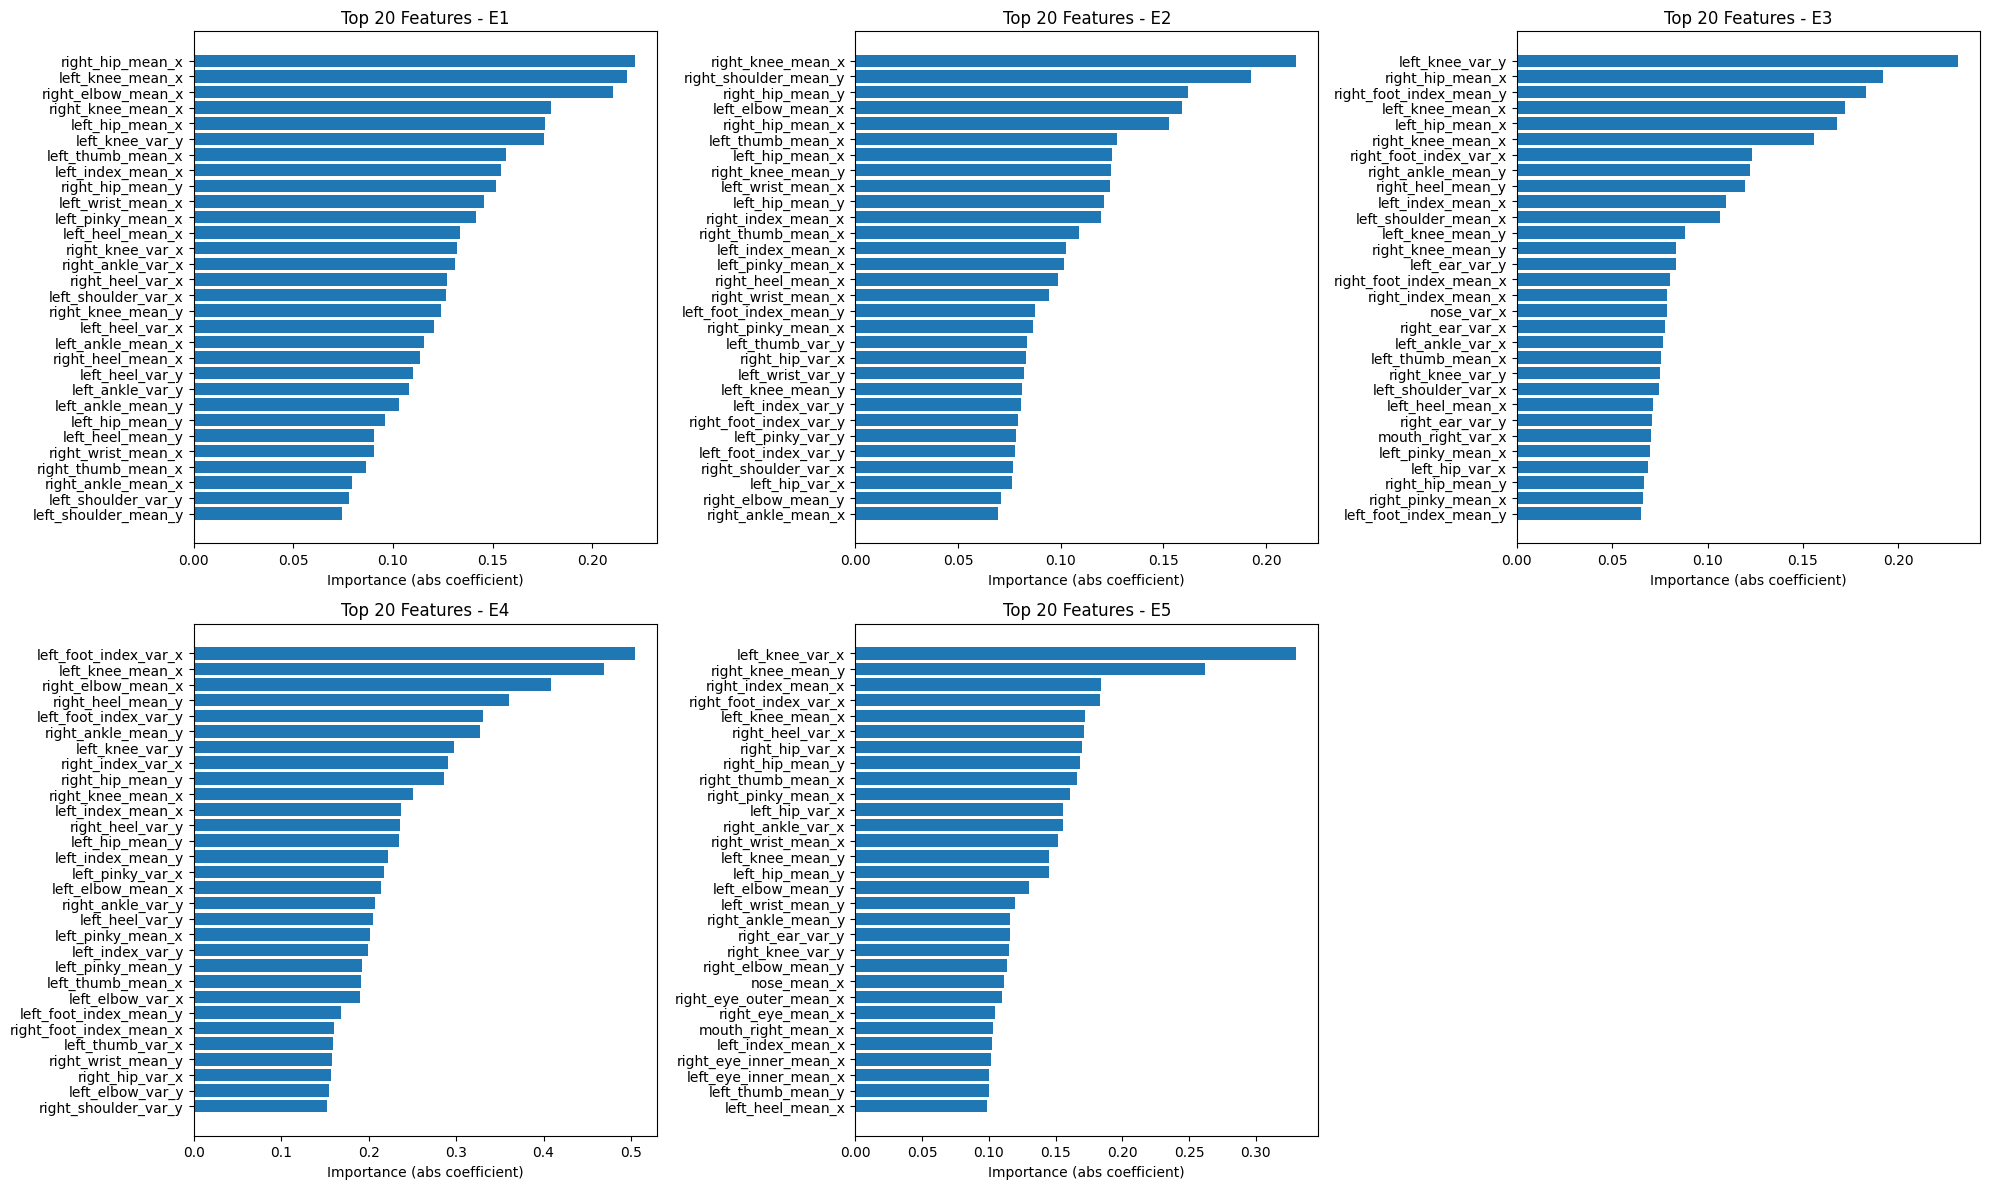

In [44]:
# Plot feature importance for each exercise
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, exercise in enumerate(exercises):
    if exercise in results:
        # Get top 20 features for this exercise
        top_features = results[exercise].head(30)
        
        # Plot
        axes[i].barh(range(len(top_features)), top_features['importance'])
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['feature'])
        axes[i].set_title(f'Top 20 Features - {exercise}')
        axes[i].set_xlabel('Importance (abs coefficient)')
        
        # Invert y-axis to have highest importance at top
        axes[i].invert_yaxis()

# Remove empty subplot if needed
if len(exercises) < 6:
    for i in range(len(exercises), 6):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [45]:
# Combine all results into one DataFrame
combined_df = pd.concat(
    [df.assign(exercise=ex) for ex, df in results.items()],
    ignore_index=True
)

# Save combined CSV
combined_df.to_csv("feature_importance_v1_baseline.csv", index=False)
print("Saved all feature importances to feature_importance_all_exercises.csv")


Saved all feature importances to feature_importance_all_exercises.csv
